In [13]:
# Cell 2 — Imports & paths
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle

from mlxtend.frequent_patterns import apriori, association_rules

# Uploaded file path
UPLOADED_USERS_CSV = './data.xlsx'
OUTPUT_DIR = '/mnt/data/project_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [15]:
# Cell 3 — Load dataset
df = pd.read_excel(UPLOADED_USERS_CSV)
print("Shape:", df.shape)
df.head()

Shape: (8000, 16)


,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B1D612FF63,Eco Yoga Mat - 90mm Thickness - Non Slip,Grocery|Beverages|Coffee|InstantCoffee,1402.45,1476.26,5%,5.0,295,Eco Yoga Mat - 90mm Thickness - Non Slip. High...,2917D3ADFDA7,Deepak Patel,R0AC51AC2386,Excellent purchase,Product had worked well till date and was havi...,https://m.media-amazon.com/images/I/B1D612FF63...,https://www.amazon.in/dp/B1D612FF63
1,BF98328691,Wireless Charger Pad - SlimFast Series 3W,Toys&Games|Educational|STEM|Robotics,1571.38,2857.06,45%,5.0,452,Wireless Charger Pad - SlimFast Series 3W. Hig...,3224A0331216,Sundeep Nair,RF0A6B7AFB6A,Poor packaging,Lightweight and compact. Perfect for travel. P...,https://m.media-amazon.com/images/I/BF98328691...,https://www.amazon.in/dp/BF98328691
2,BECC97CAFC,STEM Robot Kit - Beginner Edition (18 parts),Beauty&PersonalCare|Hair|HairCare|Shampoo,1917.72,2130.80,10%,3.6,54,STEM Robot Kit - Beginner Edition (18 parts). ...,007F9F314A7D,Rahul Gupta,R68CC3F05299,Five stars,Fantastic — will buy again.,https://m.media-amazon.com/images/I/BECC97CAFC...,https://www.amazon.in/dp/BECC97CAFC
3,B9C48D6514,Instant Coffee Sachet - 6g Pack,Electronics|Mobile|Accessories|Chargers|USB-C,3623.86,3623.86,0%,4.7,182,Instant Coffee Sachet - 6g Pack. High quality ...,44CB5E7DFD1E,Neha Singh,R1F9248C6083,As of now seems good,Decent for the price. Could be improved.,https://m.media-amazon.com/images/I/B9C48D6514...,https://www.amazon.in/dp/B9C48D6514
4,B97788B185,Wireless Charger Pad - SlimFast Series 60W,Sports&Outdoors|Fitness|Yoga|Mats,2845.97,5691.95,50%,5.0,171,Wireless Charger Pad - SlimFast Series 60W. Hi...,6868BD692DAD,Priya Patel,RE1BE3D6D1E5,Average,Not compatible with my device as advertised.,https://m.media-amazon.com/images/I/B97788B185...,https://www.amazon.in/dp/B97788B185


In [16]:
# Cell 4 — Clean prices and discount
def parse_price(x):
    try:
        if pd.isna(x): return np.nan
        s = str(x).replace('₹','').replace(',','').replace('â','').strip()
        return float(s)
    except:
        return np.nan

for col in ['discounted_price','actual_price']:
    if col in df.columns:
        df[col] = df[col].apply(parse_price)

def parse_pct(x):
    try:
        if pd.isna(x): return 0.0
        return float(str(x).replace('%','').strip())
    except:
        return 0.0

if 'discount_percentage' in df.columns:
    df['discount_percentage'] = df['discount_percentage'].apply(parse_pct)

df['rating'] = pd.to_numeric(df['rating'], errors='coerce').fillna(3.0)
df['price_diff'] = df['actual_price'] - df['discounted_price']
df['category_top'] = df['category'].apply(lambda x: str(x).split('|')[0] if pd.notna(x) else 'Unknown')
df.head()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link,price_diff,category_top
0,B1D612FF63,Eco Yoga Mat - 90mm Thickness - Non Slip,Grocery|Beverages|Coffee|InstantCoffee,1402.45,1476.26,5.0,5.0,295,Eco Yoga Mat - 90mm Thickness - Non Slip. High...,2917D3ADFDA7,Deepak Patel,R0AC51AC2386,Excellent purchase,Product had worked well till date and was havi...,https://m.media-amazon.com/images/I/B1D612FF63...,https://www.amazon.in/dp/B1D612FF63,73.81,Grocery
1,BF98328691,Wireless Charger Pad - SlimFast Series 3W,Toys&Games|Educational|STEM|Robotics,1571.38,2857.06,45.0,5.0,452,Wireless Charger Pad - SlimFast Series 3W. Hig...,3224A0331216,Sundeep Nair,RF0A6B7AFB6A,Poor packaging,Lightweight and compact. Perfect for travel. P...,https://m.media-amazon.com/images/I/BF98328691...,https://www.amazon.in/dp/BF98328691,1285.68,Toys&Games
2,BECC97CAFC,STEM Robot Kit - Beginner Edition (18 parts),Beauty&PersonalCare|Hair|HairCare|Shampoo,1917.72,2130.80,10.0,3.6,54,STEM Robot Kit - Beginner Edition (18 parts). ...,007F9F314A7D,Rahul Gupta,R68CC3F05299,Five stars,Fantastic — will buy again.,https://m.media-amazon.com/images/I/BECC97CAFC...,https://www.amazon.in/dp/BECC97CAFC,213.08,Beauty&PersonalCare
3,B9C48D6514,Instant Coffee Sachet - 6g Pack,Electronics|Mobile|Accessories|Chargers|USB-C,3623.86,3623.86,0.0,4.7,182,Instant Coffee Sachet - 6g Pack. High quality ...,44CB5E7DFD1E,Neha Singh,R1F9248C6083,As of now seems good,Decent for the price. Could be improved.,https://m.media-amazon.com/images/I/B9C48D6514...,https://www.amazon.in/dp/B9C48D6514,0.00,Electronics
4,B97788B185,Wireless Charger Pad - SlimFast Series 60W,Sports&Outdoors|Fitness|Yoga|Mats,2845.97,5691.95,50.0,5.0,171,Wireless Charger Pad - SlimFast Series 60W. Hi...,6868BD692DAD,Priya Patel,RE1BE3D6D1E5,Average,Not compatible with my device as advertised.,https://m.media-amazon.com/images/I/B97788B185...,https://www.amazon.in/dp/B97788B185,2845.98,Sports&Outdoors


In [17]:
# Cell 5 — User-level aggregation
user_agg = df.groupby('user_id').agg(
    user_name=('user_name','first'),
    avg_rating_given=('rating','mean'),
    review_count=('review_id','count'),
    avg_discount_seen=('discount_percentage','mean'),
    avg_price_seen=('discounted_price','mean')
).reset_index()

user_agg['avg_rating_given'] = user_agg['avg_rating_given'].fillna(user_agg['avg_rating_given'].mean())
user_agg['avg_discount_seen'] = user_agg['avg_discount_seen'].fillna(0.0)
user_agg['avg_price_seen'] = user_agg['avg_price_seen'].fillna(user_agg['avg_price_seen'].median())
user_agg.head()


,user_id,user_name,avg_rating_given,review_count,avg_discount_seen,avg_price_seen
0,001814787220,Manav Chatterjee,4.000000,2,57.5,1493.870000
1,00212A1CD83E,Khaja Iyer,3.166667,3,45.0,1413.720000
2,004C127FB200,Deepak Reddy,3.433333,3,30.0,2246.253333
3,004F879F9B63,Priya Singh,3.900000,4,40.0,1893.280000
4,007DCF90A03E,Neha Mehta,4.240000,5,11.0,2077.830000


Silhouette scores: {2: 0.21160479014629646, 3: 0.20476349836231633, 4: 0.21407541764818433, 5: 0.21518254646075044, 6: 0.19042250340024408, 7: 0.18940120947800312}
Best cluster count: 5


C:\Users\srija\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\srija\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\srija\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


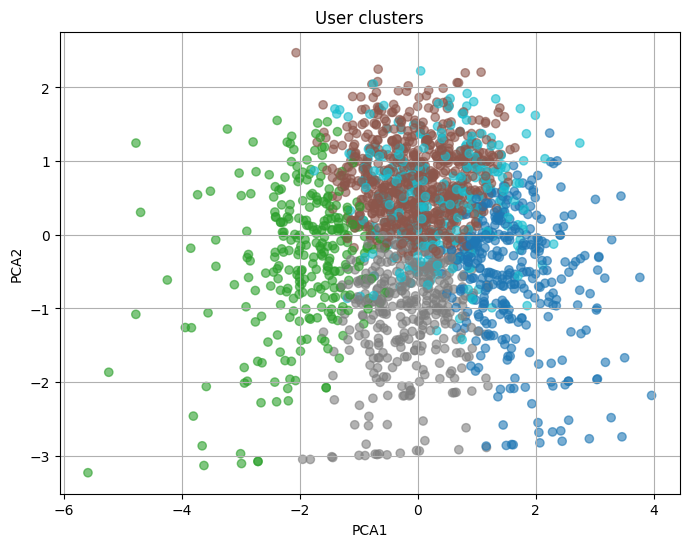

In [18]:
# Cell 6 — Segmentation with KMeans + PCA
features = ['avg_rating_given','review_count','avg_discount_seen','avg_price_seen']
X = user_agg[features].copy()
X['review_count_log'] = np.log1p(X['review_count'])
X_model = X[['avg_rating_given','review_count_log','avg_discount_seen','avg_price_seen']].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_model)

# PCA for viz
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
user_agg['pca1'] = X_pca[:,0]
user_agg['pca2'] = X_pca[:,1]

# silhouette score to find best K
sil_scores = {}
for k in range(2,8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores[k] = silhouette_score(X_scaled, labels)
print("Silhouette scores:", sil_scores)

best_k = max(sil_scores, key=sil_scores.get)
print("Best cluster count:", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
user_agg['cluster'] = kmeans.fit_predict(X_scaled)

# Plot clusters
plt.figure(figsize=(8,6))
plt.scatter(user_agg['pca1'], user_agg['pca2'], c=user_agg['cluster'], cmap='tab10', alpha=0.6)
plt.xlabel('PCA1'); plt.ylabel('PCA2'); plt.title('User clusters')
plt.grid(True); plt.show()


In [19]:
# Cell 7 — Recommender System using TruncatedSVD (matrix factorization)
ratings_df = df[['user_id','product_id','rating']].copy().dropna()
ratings_matrix = ratings_df.pivot_table(index='user_id', columns='product_id', values='rating').fillna(0)

svd = TruncatedSVD(n_components=20, random_state=42)
latent_matrix = svd.fit_transform(ratings_matrix)
product_matrix = svd.components_.T

print("Latent matrix shape:", latent_matrix.shape, "Product matrix shape:", product_matrix.shape)

# Function: recommend top-N for a user
def recommend_products(user_id, n=5):
    if user_id not in ratings_matrix.index:
        return []
    user_idx = ratings_matrix.index.get_loc(user_id)
    scores = np.dot(latent_matrix[user_idx], product_matrix.T)
    rated_products = ratings_matrix.loc[user_id]
    rated_indices = rated_products[rated_products>0].index
    scores = pd.Series(scores, index=ratings_matrix.columns)
    scores = scores.drop(rated_indices, errors='ignore')
    return scores.sort_values(ascending=False).head(n)

# Example
sample_user = ratings_matrix.index[0]
print("Top recommendations for user:", sample_user)
print(recommend_products(sample_user, n=5))


Latent matrix shape: (1969, 20) Product matrix shape: (300, 20)
Top recommendations for user: 001814787220
product_id
BA8AB9AE39    0.401753
BCF6C94923    0.235763
BD403479F7    0.211443
BF50776786    0.204326
BF88328FEB    0.200014
dtype: float64


In [29]:
# Cell 8 — Association Rules (Market Basket Analysis)
from mlxtend.frequent_patterns import apriori, association_rules

basket = ratings_df.copy()
basket['count'] = 1

# Pivot: user-product matrix
user_product = basket.groupby(['user_id','product_id'])['count'].sum().unstack(fill_value=0)

# Convert to boolean
user_product = user_product > 0

# Filter for popular products (appeared at least 5 times)
product_popularity = user_product.sum(axis=0).sort_values(ascending=False)
top_products = product_popularity[product_popularity >= 5].index.tolist()
user_product_top = user_product[top_products]

# Generate frequent itemsets
frequent_itemsets = apriori(user_product_top, min_support=0.002, use_colnames=True)

# Association rules (new version requires `num_itemsets`)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0, num_itemsets=len(frequent_itemsets))

# Show top rules
rules.sort_values('lift', ascending=False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
41,(B7077B593E),(BF972256A7),0.013205,0.008634,0.002031,0.153846,17.819005,1.0,0.001917,1.171615,0.956511,0.102564,0.146477,0.194570
40,(BF972256A7),(B7077B593E),0.008634,0.013205,0.002031,0.235294,17.819005,1.0,0.001917,1.290425,0.952100,0.102564,0.225061,0.194570
33,(BDA4476FE7),(B2A6B9AFBD),0.012189,0.014728,0.002031,0.166667,11.316092,1.0,0.001852,1.182326,0.922879,0.081633,0.154210,0.152299
32,(B2A6B9AFBD),(BDA4476FE7),0.014728,0.012189,0.002031,0.137931,11.316092,1.0,0.001852,1.145861,0.925258,0.081633,0.127294,0.152299
34,(BBEF22F79E),(B061F5DA8C),0.014220,0.012697,0.002031,0.142857,11.251429,1.0,0.001851,1.151854,0.924266,0.081633,0.131834,0.151429
35,(B061F5DA8C),(BBEF22F79E),0.012697,0.014220,0.002031,0.160000,11.251429,1.0,0.001851,1.173547,0.922840,0.081633,0.147883,0.151429
39,(BD403479F7),(B4A1AF74E7),0.013713,0.013205,0.002031,0.148148,11.219373,1.0,0.001850,1.158412,0.923532,0.081633,0.136749,0.150997
38,(B4A1AF74E7),(BD403479F7),0.013205,0.013713,0.002031,0.153846,11.219373,1.0,0.001850,1.165612,0.923057,0.081633,0.142082,0.150997
20,(BD188373C2),(B0606753A5),0.011681,0.016252,0.002031,0.173913,10.701087,1.0,0.001842,1.190853,0.917266,0.078431,0.160266,0.149457
21,(B0606753A5),(BD188373C2),0.016252,0.011681,0.002031,0.125000,10.701087,1.0,0.001842,1.129507,0.921528,0.078431,0.114658,0.149457


In [30]:
print("Number of frequent itemsets:", len(frequent_itemsets))
print(frequent_itemsets.head())


Number of frequent itemsets: 321
    support      itemsets
0  0.020315  (B43FD38590)
1  0.020315  (B0E0018E22)
2  0.020315  (B79C7B0263)
3  0.019807  (BAE003036A)
4  0.019807  (BA007CBBE1)


In [31]:
# Cell 9 — Save outputs for portfolio
user_agg.to_csv(os.path.join(OUTPUT_DIR,'user_segments.csv'), index=False)
ratings_matrix.to_csv(os.path.join(OUTPUT_DIR,'ratings_matrix.csv'))
frequent_itemsets.to_csv(os.path.join(OUTPUT_DIR,'frequent_itemsets.csv'), index=False)
rules.to_csv(os.path.join(OUTPUT_DIR,'association_rules.csv'), index=False)

with open(os.path.join(OUTPUT_DIR,'kmeans_model.pkl'),'wb') as f:
    pickle.dump(kmeans,f)
with open(os.path.join(OUTPUT_DIR,'svd_model.pkl'),'wb') as f:
    pickle.dump(svd,f)

print("Saved artifacts in:", OUTPUT_DIR)


Saved artifacts in: /mnt/data/project_outputs
